In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman

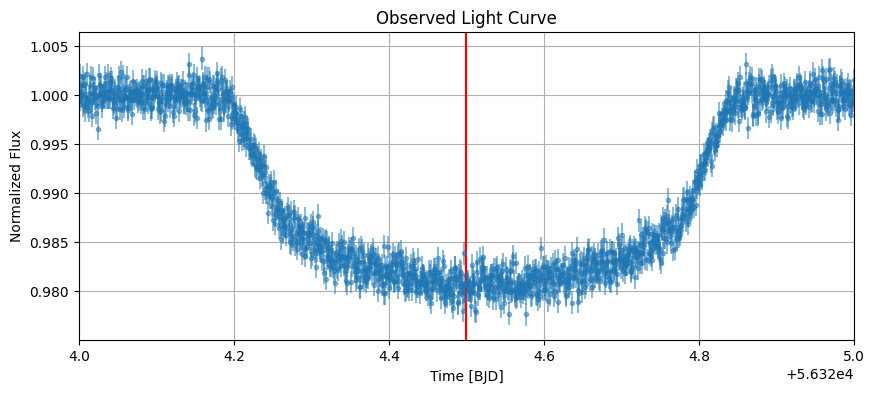

In [2]:
# Load your data: time, observed flux, and flux uncertainties
data = np.loadtxt('/pscratch/sd/e/emmayu/kipping_exomoons/KIC-3239945/photometry/planet1/AVG_SAP.dat')
time = data[:,0]
flux = data[:,1]
flux_err = data[:,2]


# Quick sanity plot
plt.figure(figsize=(10, 4))
plt.errorbar(time, flux, yerr=flux_err, fmt='.', alpha=0.5)
plt.title("Observed Light Curve")
plt.xlabel("Time [BJD]")
plt.ylabel("Normalized Flux")
plt.xlim(56324, 56325)  # Zoom here
plt.axvline(56324.5, color='r')
plt.axvline(56324.5, color='r')


plt.grid(True)
plt.show()



## Define Model Flux Generator

In [3]:
def lightcurve_planet(time, t0, period, rp, a, inc, q1, q2):
    params = batman.TransitParams()
    params.t0 = t0                # mid-transit time
    params.per = period           # orbital period
    params.rp = rp                # planet/star radius ratio
    params.a = a                  # semi-major axis (in stellar radii)
    params.inc = inc              # inclination in degrees
    params.ecc = 0.0              # assume circular
    params.w = 90.0               # argument of periastron
    params.limb_dark = "quadratic"
    params.u = [q1, q2]           # quadratic limb darkening

    m = batman.TransitModel(params, time, supersample_factor=30, exp_time=29.4/60/24)
    return m.light_curve(params)

In [4]:
def lightcurve_ttv(time, transit_times, period, rp, a, inc, q1, q2):
    """
    Builds a light curve with separate t0 for each transit.

    transit_times: list or array of τi (per-transit midpoints)
    """
    model_flux = np.ones_like(time)

    for t0 in transit_times:
        params = batman.TransitParams()
        params.t0 = t0
        params.per = period
        params.rp = rp
        params.a = a
        params.inc = inc
        params.ecc = 0.0
        params.w = 90.0
        params.limb_dark = "quadratic"
        params.u = [q1, q2]

        m = batman.TransitModel(params, time, supersample_factor=30, exp_time=29.4/60/24)
        model_flux *= m.light_curve(params)  # combine multiplicatively
    return model_flux


In [5]:
def lightcurve_moon_simple(params_planet, params_moon, t):
    # Simple sum/combination of planet + moon Mandel-Agol light curves

    # Planet LC
    lc_planet = mandel_agol(params_planet, t)

    # Moon LC: smaller radius, phase offset (e.g. moon transits offset in time)
    # Assume moon radius ratio rm, and moon transit time offset t_moon_offset
    t_moon_offset = params_moon.get('t0_offset', 0)
    params_moon_copy = params_planet.copy()
    params_moon_copy['rp'] = params_moon['rp']  # moon radius ratio
    params_moon_copy['t0'] = params_planet['t0'] + t_moon_offset

    lc_moon = mandel_agol(params_moon_copy, t)

    # Combine light curves by multiplying fluxes (assuming normalized flux ~1 out of transit)
    lc_combined = lc_planet * lc_moon

    return lc_combined

In [6]:
# Mandel-Agol wrapper for planet/moon model
def mandel_agol(params_dict, time):
    params = batman.TransitParams()
    params.t0 = params_dict['t0']
    params.per = params_dict['period']
    params.rp = params_dict['rp']
    params.a = params_dict['a']
    params.inc = params_dict['inc']
    params.ecc = 0.0
    params.w = 90.0
    params.limb_dark = "quadratic"
    params.u = [params_dict['q1'], params_dict['q2']]
    
    m = batman.TransitModel(params, time, supersample_factor=30, exp_time=29.4/60/24)
    return m.light_curve(params)


In [7]:
def compute_chi_squared(model_flux, obs_flux, flux_err):
    return np.sum(((obs_flux - model_flux) / flux_err) ** 2)


## Define Optimizer

In [12]:
planet_param_names = ['t0', 'period', 'rp', 'a', 'inc', 'q1', 'q2']
moon_param_names = ['rp', 't0_offset']


In [13]:
def pack_params(params_dict, keys):
    return np.array([params_dict[k] for k in keys])

def unpack_params(param_array, keys):
    return dict(zip(keys, param_array))


In [14]:
def residuals_planet_only(param_array, t, flux, flux_err):
    params = unpack_params(param_array, planet_param_names)
    model_flux = lightcurve_planet(t, **params)
    return (model_flux - flux) / flux_err

def residuals_planet_moon(param_array, t, flux, flux_err):
    # Split into planet and moon parts
    planet_part = param_array[:len(planet_param_names)]
    moon_part = param_array[len(planet_param_names):]

    planet_params = unpack_params(planet_part, planet_param_names)
    moon_params = unpack_params(moon_part, moon_param_names)

    model_flux = lightcurve_moon_simple(planet_params, moon_params, t)
    return (model_flux - flux) / flux_err


In [50]:
# Assumes time, obs_flux, flux_err are defined
planet_params = {
    't0': 55253.28659,
    'period': 1071.23285,
    'rp': 0.12434,
    'a': 442.75,
    'inc': 89.966,
    'q1': 0.44107,
    'q2': 0.48971
}
moon_params = {
    "rp": 0.12434,
    "t0_offset": -0.1
}



In [54]:
# Initial guesses
planet_init = pack_params(planet_params, planet_param_names)
moon_init = pack_params(moon_params, moon_param_names)
both_init = np.concatenate([planet_init, moon_init])

# Example bounds (adjust as needed)
planet_bounds = ([55000, 1000, 0, 100, 80, 0, 0], [56000, 1100, 1, 1000, 90, 1, 1])
moon_bounds = ([0, -1], [1, 1])
both_bounds = (np.concatenate([planet_bounds[0], moon_bounds[0]]),
               np.concatenate([planet_bounds[1], moon_bounds[1]]))
'''
't0': 55253.28659,
    'period': 1071.23285,
    'rp': 0.12434,
    'a': 442.75,
    'inc': 89.966,
    'q1': 0.44107,
    'q2': 0.48971
}
moon_params = {
    "rp": 0.12434,
    "t0_offset": -0.1
}

'''


'\n\'t0\': 55253.28659,\n    \'period\': 1071.23285,\n    \'rp\': 0.12434,\n    \'a\': 442.75,\n    \'inc\': 89.966,\n    \'q1\': 0.44107,\n    \'q2\': 0.48971\n}\nmoon_params = {\n    "rp": 0.12434,\n    "t0_offset": -0.1\n}\n\n'

In [55]:
from scipy.optimize import least_squares

res_planet = least_squares(
    residuals_planet_only,
    planet_init,
    bounds=planet_bounds,
    args=(time, flux, flux_err),
    method='trf',
    verbose=2
)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9656e+04                                    4.15e+07    
       1              3         1.0101e+04      9.56e+03       2.96e+00       1.92e+06    
       2              4         5.0876e+03      5.01e+03       7.79e+00       2.53e+06    
       3              5         4.9234e+03      1.64e+02       2.05e+01       1.09e+05    
       4              6         4.8173e+03      1.06e+02       4.09e+01       5.10e+04    
       5              7         4.7761e+03      4.12e+01       2.28e+01       3.24e+04    
       6              8         4.7661e+03      1.00e+01       2.17e+01       1.26e+05    
       7              9         4.7605e+03      5.61e+00       2.17e+00       2.68e+04    
       8             10         4.7594e+03      1.06e+00       1.18e+01       7.01e+04    
       9             11         4.7580e+03      1.45e+00       3.97e-01       1.34e+04    

In [56]:
res_moon = least_squares(
    residuals_planet_moon,
    both_init,
    bounds=both_bounds,
    args=(time, flux, flux_err),
    method='trf',
    verbose=2
)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2426e+05                                    5.48e+08    
       1              2         8.7295e+04      1.37e+05       2.78e+01       4.87e+06    
       2              5         2.6189e+04      6.11e+04       1.42e-01       4.70e+07    
       3              6         7.8927e+03      1.83e+04       6.96e-01       3.17e+06    
       4              7         7.7681e+03      1.25e+02       1.62e+00       8.01e+05    
       5              8         6.8047e+03      9.63e+02       6.61e-01       1.55e+06    
       6              9         6.6562e+03      1.49e+02       8.83e-01       1.19e+05    
       7             10         6.4548e+03      2.01e+02       2.84e+00       1.29e+05    
       8             11         6.1750e+03      2.80e+02       6.38e+00       7.50e+04    
       9             12         5.7684e+03      4.07e+02       1.32e+01       1.53e+05    

In [57]:
def compute_chi2(res):
    chi2 = np.sum(res.fun**2)
    dof = len(flux) - len(res.x)
    return chi2, chi2 / dof

chi2_planet, redchi2_planet = compute_chi2(res_planet)
chi2_moon, redchi2_moon = compute_chi2(res_moon)

print("Planet-only reduced chi^2:", redchi2_planet)
print("Planet+Moon reduced chi^2:", redchi2_moon)


Planet-only reduced chi^2: 1.0029008294578532
Planet+Moon reduced chi^2: 1.0897885263569607


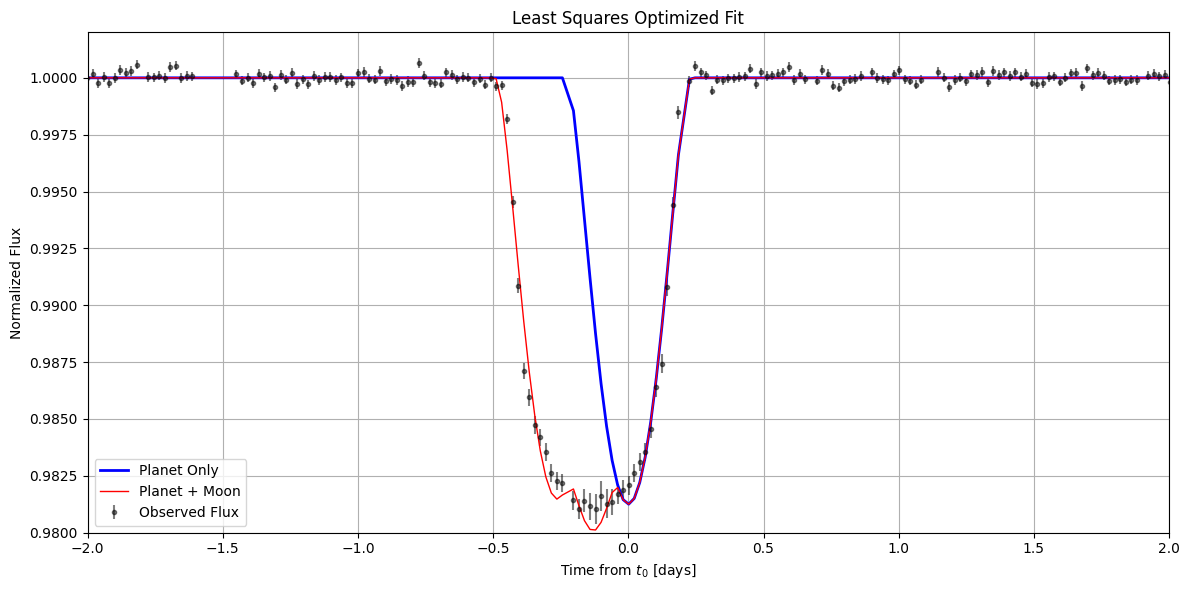

In [59]:
# Use optimized planet+moon model result (res_moon)
fitted_planet_params = unpack_params(res_moon.x[:len(planet_param_names)], planet_param_names)
fitted_moon_params = unpack_params(res_moon.x[len(planet_param_names):], moon_param_names)

# Center time on best-fit t0
t0_fit = fitted_planet_params['t0']
time_centered = time - t0_fit

# Sort data for smooth plotting
sorted_idx = np.argsort(time_centered)
time_sorted = time_centered[sorted_idx]
flux_sorted = flux[sorted_idx]
flux_err_sorted = flux_err[sorted_idx]

# Recompute model light curves at sorted time (converted back to absolute)
t_absolute = time_sorted + t0_fit
model_flux_planet = lightcurve_planet(t_absolute, **fitted_planet_params)
model_flux_moon = lightcurve_moon_simple(fitted_planet_params, fitted_moon_params, t_absolute)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.errorbar(time_sorted, flux_sorted, yerr=flux_err_sorted, fmt='.', color='black', alpha=0.5, label="Observed Flux")
plt.plot(time_sorted, model_flux_planet, label="Planet Only", lw=2, color='blue')
plt.plot(time_sorted, model_flux_moon, label="Planet + Moon", lw=1, color='red')

plt.xlim(-2, 2)   # Adjust window as needed
plt.ylim(0.98, 1.002)

plt.xlabel("Time from $t_0$ [days]")
plt.ylabel("Normalized Flux")
plt.title("Least Squares Optimized Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Example

In [60]:
# Model 1: Planet only
model_flux_planet = lightcurve_planet(time, **planet_params)
chi2_planet = compute_chi_squared(model_flux_planet, flux, flux_err)

# Model 3: Planet + Moon
model_flux_moon = lightcurve_moon_simple(planet_params, moon_params, time)
chi2_moon = compute_chi_squared(model_flux_moon, flux, flux_err)

# Print results
print("Chi² values:")
print(f"  Planet only:     {chi2_planet:.2f}")
#print(f"  Planet + TTV:    {chi2_ttv:.2f}")
print(f"  Planet + Moon:   {chi2_moon:.2f}")

Chi² values:
  Planet only:     39312.48
  Planet + Moon:   448513.52


In [ ]:
dof = len(flux) - len(res.x)
39312.48/dof


In [61]:
'''
# Model 2: TTV
model_flux_ttv = lightcurve_ttv(time, ttv_transit_times, planet_params['period'],
                                 planet_params['rp'], planet_params['a'],
                                 planet_params['inc'], planet_params['q1'], planet_params['q2'])
chi2_ttv = compute_chi_squared(model_flux_ttv, obs_flux, flux_err)
'''


"\n# Model 2: TTV\nmodel_flux_ttv = lightcurve_ttv(time, ttv_transit_times, planet_params['period'],\n                                 planet_params['rp'], planet_params['a'],\n                                 planet_params['inc'], planet_params['q1'], planet_params['q2'])\nchi2_ttv = compute_chi_squared(model_flux_ttv, obs_flux, flux_err)\n"

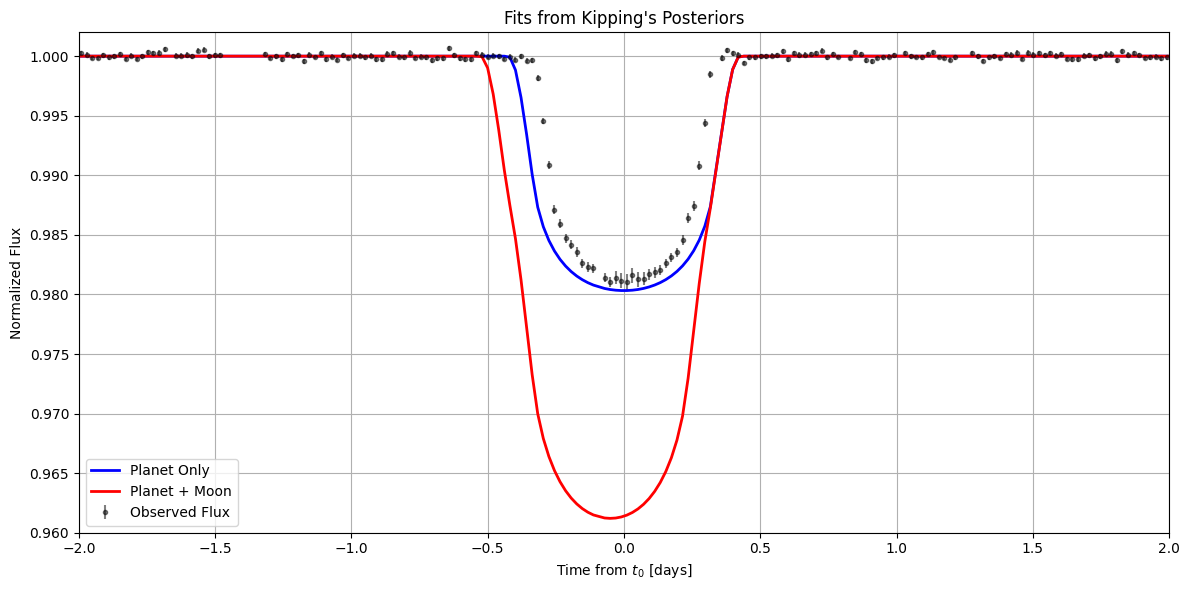

In [65]:
# Recenter time around the planet mid-transit t0
t0 = planet_params['t0']
time_centered = time - t0

# Sort for plotting
sorted_idx = np.argsort(time_centered)
time_sorted = time_centered[sorted_idx]
flux_sorted = flux[sorted_idx]
flux_err_sorted = flux_err[sorted_idx]

# Re-evaluate models on centered time (convert back to absolute BJD for batman)
t_absolute = time_sorted + t0

model_flux_planet = lightcurve_planet(t_absolute, **planet_params)
model_flux_moon = lightcurve_moon_simple(planet_params, moon_params, t_absolute)

# Plot everything
plt.figure(figsize=(12, 6))

plt.errorbar(time_sorted, flux_sorted, yerr=flux_err_sorted, fmt='.', color='black', alpha=0.5, label="Observed Flux")

plt.plot(time_sorted, model_flux_planet, label="Planet Only", lw=2, color='blue')
plt.plot(time_sorted, model_flux_moon, label="Planet + Moon", lw=2, color='red')

plt.xlim(-2, 2)  # Adjust this if your transit is more/less spread out
plt.ylim(0.96, 1.002)

plt.xlabel("Time from $t_0$ [days]")
plt.ylabel("Normalized Flux")
plt.title("Fits from Kipping's Posteriors")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()